In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333: #and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:44<00:00, 236.40it/s]


10556

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10556, (174625,))

In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# standard = StandardScaler()
# adjusted_recordings = standard.fit_transform(adjusted_recordings)
#print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(adjusted_recordings, valence_values, test_size=0.2, random_state=42)




############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211445\AppData\Local\Temp\ipykernel_3900\2777483405.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([8444, 1, 174625]), torch.Size([8444]))

In [15]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau



class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, dilation=1):
        super(ResidualBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2  # Adjust padding to maintain size

        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        #  addition of input to the output
        out += residual  
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=64, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.3))


        self.layers.append(ResidualBlock(64))
        
        conv2 = nn.Conv1d(in_channels=64, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1,dilation=2)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(1104,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
            
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))



def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')



############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  # Set the model to evaluation mode
    data = data.to(device)  # Move the data to the same device as the model
    with torch.no_grad():  # Turn off gradients to speed up this part
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  # Add batch dimension
            output = model(sample)
            predictions.append(output.item())
    return predictions


            
        

        


In [17]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.001)

#optimizer=optim.SGD(modelCNN.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=124)

  1%|          | 1/124 [00:10<21:37, 10.55s/it]

Epoch [1/124], Loss: 3.8887
--------------------------------------------------


  2%|▏         | 2/124 [00:21<22:27, 11.05s/it]

Epoch [2/124], Loss: 0.9466
--------------------------------------------------
Epoch [3/124], Loss: 0.7793


  2%|▏         | 3/124 [00:33<23:01, 11.41s/it]

Mean Squared Error: 0.7363 and Mean Absolute Error: 0.6780
None
--------------------------------------------------
Epoch [4/124], Loss: 0.7125


  3%|▎         | 4/124 [00:45<23:05, 11.55s/it]

Mean Squared Error: 0.6066 and Mean Absolute Error: 0.6295
None
--------------------------------------------------


  3%|▎         | 4/124 [00:49<24:48, 12.40s/it]


KeyboardInterrupt: 

Mean Squared Error: 0.3938 and Mean Absolute Error: 0.5064


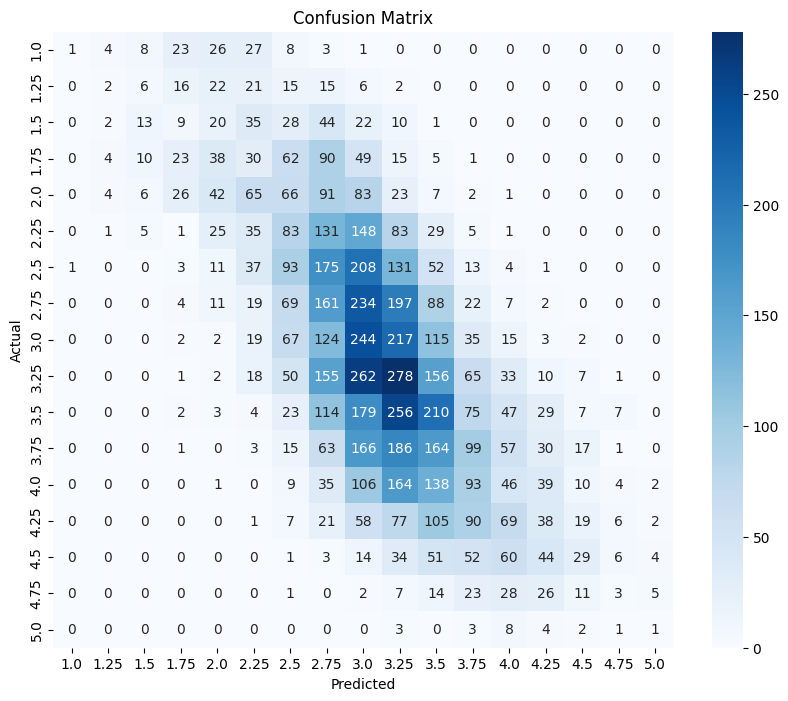

Accuracy: 0.1561


In [ ]:
evaluate_model(modelCNN, train_loader,conf=True)

# Official Test Data

In [11]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/test'
test_label = {}
lenghts = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            test_label[filename] = data['audio_data']
            lenghts.append(len(data['audio_data']))
print(max(lenghts))
            

100%|██████████| 1863/1863 [00:25<00:00, 72.63it/s]

133534


In [12]:
for recording_test in test_label:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(test_label[recording_test], (max_length // len(test_label[recording_test]) + 1))[:max_length]
    test_label[recording_test] = repeated_recording
    
for i in test_label:
    print(i, test_label[i].shape)



10011.pkl (174625,)
10025.pkl (174625,)
10033.pkl (174625,)
10036.pkl (174625,)
10043.pkl (174625,)
10067.pkl (174625,)
10074.pkl (174625,)
10079.pkl (174625,)
10083.pkl (174625,)
10090.pkl (174625,)
10092.pkl (174625,)
10097.pkl (174625,)
10099.pkl (174625,)
10110.pkl (174625,)
10116.pkl (174625,)
10120.pkl (174625,)
10149.pkl (174625,)
10179.pkl (174625,)
10184.pkl (174625,)
10189.pkl (174625,)
10191.pkl (174625,)
10192.pkl (174625,)
10194.pkl (174625,)
10200.pkl (174625,)
10202.pkl (174625,)
10204.pkl (174625,)
10206.pkl (174625,)
10207.pkl (174625,)
10216.pkl (174625,)
10222.pkl (174625,)
10224.pkl (174625,)
10235.pkl (174625,)
10236.pkl (174625,)
10240.pkl (174625,)
10242.pkl (174625,)
10251.pkl (174625,)
10253.pkl (174625,)
10259.pkl (174625,)
10267.pkl (174625,)
10271.pkl (174625,)
10277.pkl (174625,)
10279.pkl (174625,)
10286.pkl (174625,)
10287.pkl (174625,)
10288.pkl (174625,)
10290.pkl (174625,)
10291.pkl (174625,)
10293.pkl (174625,)
10306.pkl (174625,)
10315.pkl (174625,)


In [13]:
FinalTestAudio = []
for i in test_label:
    FinalTestAudio.append(test_label[i])

FinalTestDataset = torch.tensor(FinalTestAudio, dtype=torch.float32).unsqueeze(1)

results = predict(modelCNN, FinalTestDataset, device)
print(len(results))


1863


In [14]:
import pandas as pd
labels_final = test_label.keys()
labels_final = list(labels_final)   
df = pd.DataFrame({'ID': labels_final, 'Label': results})
df.to_csv('results3.csv', index=False)

In [ ]:
df

,ID,Label
0,10011.pkl,3.208400
1,10025.pkl,1.919598
2,10033.pkl,3.702743
3,10036.pkl,3.106718
4,10043.pkl,4.340781
...,...,...
1858,22393.pkl,3.560573
1859,22394.pkl,3.441071
1860,22400.pkl,4.751411
1861,22401.pkl,2.092293
